In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Douban Movie Data Processing

In [2]:
data_pd = pd.read_csv("douban_movie.tsv",header=0,sep='\t')
data_pd.head(2)

,UserId,ItemId,Rating,Timestamp
0,630157,0,5,1.182010e+09
1,630157,1,5,1.182010e+09


In [3]:
data_pd.shape

(11742260, 4)

In [4]:
data_pd[data_pd['Rating']==-1].shape # interact but not rate

(2652182, 4)

<AxesSubplot:xlabel='UserId'>

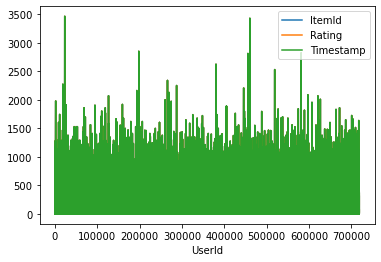

In [5]:
data_pd.groupby('UserId').count().plot() # rough frequencies of userid

In [6]:
data_pd['date'] = pd.to_datetime(data_pd['Timestamp'],unit='s')
data_pd.head(2)

,UserId,ItemId,Rating,Timestamp,date
0,630157,0,5,1.182010e+09,2007-06-16 16:00:00
1,630157,1,5,1.182010e+09,2007-06-16 16:00:00


In [7]:
data_pd['date'].min()

Timestamp('2005-05-08 16:00:00')

In [8]:
data_pd['date'].max()

Timestamp('2017-03-17 16:00:00')

In [9]:
data_pd.shape

(11742260, 5)

<AxesSubplot:xlabel='year'>

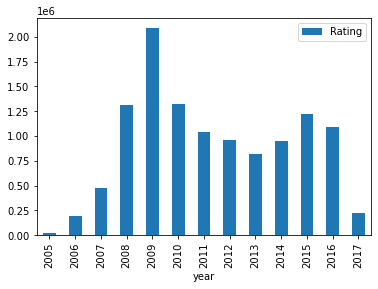

In [10]:
data_pd['year'] = data_pd['date'].dt.year
data_pd.groupby(['year']).agg({'Rating':'count'}).sort_values('year').plot(kind='bar')

In [11]:
# take data after year 2010
data_pd = data_pd[data_pd['year']>=2010]
data_pd = data_pd.drop_duplicates(subset=['UserId','ItemId'],ignore_index=True)
data_pd.shape

(7601284, 6)

In [12]:
data_pd.groupby('Rating').agg({'ItemId':'count'}) # rating counts

,ItemId
Rating,
-1,1447871
1,89091
2,245356
3,1420150
4,2460232
5,1938584


In [13]:
data_pd

,UserId,ItemId,Rating,Timestamp,date,year
0,630154,383,5,1.262880e+09,2010-01-07 16:00:00,2010
1,630154,384,5,1.274026e+09,2010-05-16 16:00:00,2010
2,630154,385,4,1.274026e+09,2010-05-16 16:00:00,2010
3,630154,386,3,1.274026e+09,2010-05-16 16:00:00,2010
4,630154,387,3,1.274026e+09,2010-05-16 16:00:00,2010
...,...,...,...,...,...,...
7601279,595933,75127,1,1.460909e+09,2016-04-17 16:00:00,2016
7601280,595933,2020,5,1.469549e+09,2016-07-26 16:00:00,2016
7601281,595933,1073,5,1.471277e+09,2016-08-15 16:00:00,2016
7601282,595933,1135,5,1.487347e+09,2017-02-17 16:00:00,2017


In [14]:
def filter_g_k_one(data,k=10,u_name='user_id',i_name='business_id',y_name='stars'):
    '''
    Filter users and items that have greater than k=10 appearance
    '''
    item_group = data.groupby(i_name).agg({y_name:'count'})
    item_g10 = item_group[item_group[y_name]>=k].index
    data_new = data[data[i_name].isin(item_g10)]
    user_group = data_new.groupby(u_name).agg({y_name:'count'})
    user_g10 = user_group[user_group[y_name]>=k].index
    data_new = data_new[data_new[u_name].isin(user_g10)]
    return data_new

def filter_tot(data,k=10,u_name='user_id',i_name='business_id',y_name='stars'):
    '''
    The function tests filter_g_k_one to make sure the filtered data set has greater-than-k users and items 
    appearance. Since when we filter user_g10 after the item filter, we may delete some users from the data set and so 
    delete some item frequencies at the same time. 
    '''
    data_new=data
    while True:
        data_new = filter_g_k_one(data_new,k=k,u_name=u_name,i_name=i_name,y_name=y_name)
        m1 = data_new.groupby(i_name).agg({y_name:'count'})
        m2 = data_new.groupby(u_name).agg({y_name:'count'})
        num1 = m1[y_name].min()
        num2 = m2[y_name].min()
        print('item min:',num1,'user min:',num2)
        if num1>=k and num2>=k:
            break
    return data_new

In [15]:
data = filter_tot(data_pd,k=10,u_name='UserId',i_name='ItemId',y_name='Rating')
data.shape

item min: 5 user min: 10
item min: 10 user min: 10


(7363764, 6)

In [16]:
data['UserId'].unique().shape

(48729,)

In [17]:
data['ItemId'].unique().shape


(26767,)

In [18]:
# split timestamp into 10 bins (time stages)
time_min = data['Timestamp'].min()
time_max = data['Timestamp'].max()
slot_gap = (time_max - time_min) /10
data['time_slot'] = data["Timestamp"].apply(lambda x: int(min(int((x-time_min))//slot_gap,9)))
data['time_slot'] = data[['time_slot']].astype(np.int)

/tmp/ipykernel_160/1052046889.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data['time_slot'] = data[['time_slot']].astype(np.int)


In [19]:
timestamp = time_min + slot_gap
import time

#convert to localtime
time_local = time.localtime(timestamp)
dt = time.strftime("%Y-%m-%d %H:%M:%S",time_local)
dt

'2010-09-21 13:48:00'

In [20]:
data.head(4)

,UserId,ItemId,Rating,Timestamp,date,year,time_slot
0,630154,383,5,1.262880e+09,2010-01-07 16:00:00,2010,0
1,630154,384,5,1.274026e+09,2010-05-16 16:00:00,2010,0
2,630154,385,4,1.274026e+09,2010-05-16 16:00:00,2010,0
3,630154,386,3,1.274026e+09,2010-05-16 16:00:00,2010,0


In [21]:
# Use first 8 bins as train slots, and the 9th bin as test slot
train_slots = [0 ,1, 2, 3, 4, 5, 6,7,8]
test_slots = [9]
data_train = data[data['time_slot'].isin(train_slots)]
data_test = data[data['time_slot'].isin(test_slots)]
print("train:",data_train.shape[0],'test:',data_test.shape[0])

train: 6625965 test: 737799


In [22]:
user_in_train = data_train['UserId'].unique()
item_in_train = data_train['ItemId'].unique()

# filter new user/item in train. Only keep user/item appeared in train set
data_test = data_test[data_test['UserId'].isin(user_in_train)]
print("user not include in user_items_test:",data_test.shape)
data_test = data_test[data_test['ItemId'].isin(item_in_train)]
print("train:",data_train.shape[0],'not-new test:',data_test.shape[0])

# filter repeat (repetitive interaction)
data_train = data_train.drop_duplicates(subset=['UserId','ItemId'],keep='first')
data_test = data_test.drop_duplicates(subset=['UserId','ItemId'],keep='first')
print("not repeat train:",data_train.shape[0],'not-repeat test:',data_test.shape[0])

user not include in user_items_test: (681284, 7)
train: 6625965 not-new test: 548253
not repeat train: 6625965 not-repeat test: 548253


In [23]:
import numpy as np
user = data_train['UserId'].unique()
item= data_train['ItemId'].unique()
# reindex user and item
user_to_id = dict(zip(list(user),list(np.arange(user.shape[0]))))
item_to_id = dict(zip(list(item),list(range(item.shape[0]))))
print("user num:",user.shape)
print("item num:", item.shape)
# map to the data sets
data_train['uid'] = data_train['UserId'].map(user_to_id)
data_train['iid'] = data_train['ItemId'].map(item_to_id)

data_test['uid'] = data_test['UserId'].map(user_to_id)
data_test['iid'] = data_test['ItemId'].map(item_to_id)

data_test.head(2)

user num: (47890,)
item num: (26047,)


,UserId,ItemId,Rating,Timestamp,date,year,time_slot,uid,iid
157,630154,540,4,1.473782e+09,2016-09-13 16:00:00,2016,9,0,840
158,630154,541,5,1.481472e+09,2016-12-11 16:00:00,2016,9,0,225



# continue

In [24]:
data_train = data_train[['uid','iid','time_slot','Rating']]
data_test = data_test[['uid','iid','time_slot','Rating']]
#
columns = ['uid','iid','time_slot','click']
data_train.columns = columns
data_test.columns = columns
data_test.head(2)

,uid,iid,time_slot,click
157,0,840,9,4
158,0,225,9,5


In [25]:
# split testing and valuation

In [26]:
test_unique_user = data_test['uid'].unique()
N_ = test_unique_user.shape[0]
np.random.seed(2020)
np.random.shuffle(test_unique_user)
split_idx  = int(N_*0.7)
test_real_user = test_unique_user[:split_idx]
valid_real_user = test_unique_user[split_idx:]
print("tot user in the last stage:",N_,"real test user:",test_real_user.shape[0],"real valid user:",valid_real_user.shape[0])

tot user in the last stage: 22821 real test user: 15974 real valid user: 6847


In [27]:
data_real_test = data_test[data_test['uid'].isin(test_real_user)]
data_real_valid = data_test[data_test['uid'].isin(valid_real_user)]
print("tot itr:",data_test.shape,"real test:",data_real_test.shape,"real valid:",data_real_valid.shape)

tot itr: (548253, 4) real test: (379537, 4) real valid: (168716, 4)


# saving

In [41]:
import os
path_folder = "./douban_moive/"
if not os.path.exists(path_folder):
    os.mkdir(path_folder)
user_items_test = data_real_test.sort_values(by='uid',ignore_index=True)
print(user_items_test.head(2))
test_itr = user_items_test.values[:,0:2]
print(test_itr.shape)
# write uid and list of iid that u interacts with
with open('./douban_moive/test_real.txt','w') as f:
    u_pre = test_itr[0,0]
    k = 0
    for x in test_itr:
        u = x[0]
        i = x[1]
        if u !=u_pre or k==0:
            u_pre = u
            if k>0:
                f.write('\n')
            f.write(str(u))
            k = 1
        f.write(' '+str(i))

   uid    iid  time_slot  click
0    3  16495          9      4
1    3  25976          9      3
(379537, 2)


In [42]:
user_items_test = data_real_valid.sort_values(by='uid',ignore_index=True)
print(user_items_test.head(2))
test_itr = user_items_test.values[:,0:2]
print(test_itr.shape)
with open('./douban_moive/valid_real.txt','w') as f:
    u_pre = test_itr[0,0]
    k = 0
    for x in test_itr:
        u = x[0]
        i = x[1]
        if u !=u_pre or k==0:
            u_pre = u
            if k>0:
                f.write('\n')
            f.write(str(u))
            k = 1
        f.write(' '+str(i))

   uid  iid  time_slot  click
0    0  840          9      4
1    0  225          9      5
(168716, 2)


In [43]:
user_items_test = data_train.sort_values(by='uid',ignore_index=True)
print(user_items_test.head(2))
test_itr = user_items_test.values[:,0:2]
print(test_itr.shape)
with open('./douban_moive/train.txt','w') as f:
    u_pre = test_itr[0,0]
    k = 0
    for x in test_itr:
        u = x[0]
        i = x[1]
        if u !=u_pre or k==0:
            u_pre = u
            if k>0:
                f.write('\n')
            f.write(str(u))
            k = 1
        f.write(' '+str(i))

   uid  iid  time_slot  click
0    0    0          0      5
1    0  100          5      5
(6625965, 2)


In [44]:
data_train.to_csv("./douban_moive/train_with_time.txt",index=False,header=False,sep=' ')

In [45]:
data_real_valid.to_csv("./douban_moive/valid_with_time.txt",index=False,header=False,sep=' ')
data_real_test.to_csv("./douban_moive/test_with_time.txt",index=False,header=False,sep=' ')

In [ ]:
data_train['iid'].max()


In [28]:
for slot_id in train_slots:
    slot_data = data_train[data_train['time_slot'].isin([slot_id])]
    slot_data  = slot_data.sort_values(by=['iid'],ignore_index=True)
    slot_data_np = slot_data[['iid','uid']].values[:,0:2]
    print(slot_data.head(2))
    print(slot_data[['iid','uid']].head(2))
    print(slot_data.shape)
    with open("./douban_moive/t_"+str(slot_id)+".txt",'w') as f:
        i_pre = slot_data_np[0,0]
        k = 0
        for x in slot_data_np:
            i_ = x[0]
            u_ = x[1]
            if i_ != i_pre or k == 0:
                i_pre = i_
                if k>0:
                    f.write('\n')
                f.write(str(i_))
                k = 1
            f.write(" " + str(u_))

    uid  iid  time_slot  click
0     0    0          0      5
1  9824    0          0     -1
   iid   uid
0    0     0
1    0  9824
(973800, 4)
     uid  iid  time_slot  click
0  25851    0          1     -1
1   8166    0          1      3
   iid    uid
0    0  25851
1    0   8166
(795705, 4)
     uid  iid  time_slot  click
0  12675    0          2      5
1  33222    0          2     -1
   iid    uid
0    0  12675
1    0  33222
(705637, 4)
     uid  iid  time_slot  click
0   7517    0          3      4
1  12320    0          3      4
   iid    uid
0    0   7517
1    0  12320
(636706, 4)
     uid  iid  time_slot  click
0  36421    0          4     -1
1  10946    0          4      3
   iid    uid
0    0  36421
1    0  10946
(631387, 4)
     uid  iid  time_slot  click
0  36789    0          5      4
1  16292    0          5      3
   iid    uid
0    0  36789
1    0  16292
(524913, 4)
     uid  iid  time_slot  click
0  36607    0          6     -1
1  39181    0          6     -1
   iid    

In [29]:
slot_data = data_test
slot_data  = slot_data.sort_values(by=['iid'],ignore_index=True)
slot_data_np = slot_data[['iid','uid']].values[:,0:2]
print(slot_data.head(2))
print(slot_data[['iid','uid']].head(2))
print(slot_data.shape)
with open("./douban_moive/t_"+str(9)+".txt",'w') as f:
    i_pre = slot_data_np[0,0]
    k = 0
    for x in slot_data_np:
        i_ = x[0]
        u_ = x[1]
        if i_ != i_pre or k == 0:
            i_pre = i_
            if k>0:
                f.write('\n')
            f.write(str(i_))
            k = 1
        f.write(" " + str(u_))


     uid  iid  time_slot  click
0  37572    0          9      5
1  38896    0          9      5
   iid    uid
0    0  37572
1    0  38896
(548253, 4)
